# A quick look at vanilla feedforward neural networks
### written by Alexandre Bazanté, January 2020

In this notbeook we set up a very general, very simple neural network.

Let's begin with importing necessary libraries

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (15,10),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25*0.75,
          'ytick.labelsize': 25*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

import numpy as np
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

The following block of code contains the entire neural network class. It is broken down by sections, and heavily commented.

See *Machine Learning Lexicon.pdf* for more details about terms commonly used.

In [2]:
class Network:
    def __init__(self, input_size, output_size=1, hidden_layers=1, neurons=1,
                 init_method='normal', activation='sigmoid', learning_rate=0.1):
        '''
        Initializes the Network Class.
        Returns nothing.
        - input_size is a positive integer
        - output_size is a positive integer
        - hidden_layers is a positive integer
        - neurons is a positive integer
        - init_method is a string referrring to the parameter initialization
            possible options are: zeros, ones, random, normal, truncated_normal, Xavier, He
        - activation is a string referrring to the activation function
            possible options are: sigmoid, tanh, reLU, leaky-reLU, softmax
        - learning_rate is a float (not enforced to be positive but it really should be)
        '''
        self.input_size = input_size
        self.output_size = output_size
        self.layers = hidden_layers
        self.neurons = neurons
        self.init_method = init_method
        self.activation = activation
        self.learning_rate = learning_rate
        
        self.layer_sizes = [input_size]
        for n in range(hidden_layers):
            self.layer_sizes.append(neurons)    # This assumes each hidden layer has the same number of neurons
        self.layer_sizes.append(output_size)
        
        # For convenience, neurons are arranged in row vectors. 
        # This is contrary to most NN graphs, but it avoids rearranging the weights 
        #     for the dot product in the feedforward evaluation and the gradient backpropagation

        # Weights and biases are kept in the self.params dictionary.
        self.params = {}
        np.random.seed(0)
        
##------------------------------------------------------
##  Parameter Initialization
##------------------------------------------------------
        for layer in range(1, len(self.layer_sizes)):
            if init_method.lower() == 'ones':
                self.params["W"+str(layer)] = np.ones((self.layer_sizes[layer-1], self.layer_sizes[layer]))
                self.params["B"+str(layer)] = np.ones((1, self.layer_sizes[layer]))
            elif init_method.lower() == 'zeros':
                self.params["W"+str(layer)] = np.zeros((self.layer_sizes[layer-1], self.layer_sizes[layer]))
                self.params["B"+str(layer)] = np.zeros((1, self.layer_sizes[layer]))
            elif init_method.lower() == 'random':
                self.params["W"+str(layer)] = np.random.rand(self.layer_sizes[layer-1], self.layer_sizes[layer])
                self.params["B"+str(layer)] = np.random.rand(1, self.layer_sizes[layer])
            elif init_method.lower() == 'normal':
                self.params["W"+str(layer)] = np.random.randn(self.layer_sizes[layer-1], self.layer_sizes[layer])
                self.params["B"+str(layer)] = np.random.randn(1, self.layer_sizes[layer])
            elif init_method.lower() == 'truncated_normal':
                rad = 1 / np.sqrt(self.layer_sizes[layer-1])
                X = truncated_normal(2, 1, -rad, rad)
                self.params["W"+str(layer)] = X.rvs((self.layer_sizes[layer-1], self.layer_sizes[layer]))
                self.params["B"+str(layer)] = X.rvs((1, self.layer_sizes[layer]))
            elif init_method.lower()== 'xavier':
                self.params["W"+str(layer)] = np.random.randn(self.layer_sizes[layer-1], self.layer_sizes[layer]) * np.sqrt(1 / self.layer_sizes[layer-1])
                self.params["B"+str(layer)] = np.random.randn(1, self.layer_sizes[layer])
            elif init_method.lower() == 'he':
                self.params["W"+str(layer)] = np.random.randn(self.layer_sizes[layer-1], self.layer_sizes[layer]) * np.sqrt(2 / self.layer_sizes[layer-1])
                self.params["B"+str(layer)] = np.random.randn(1, self.layer_sizes[layer])
            else:
                print(f"Initialization method \'{init_method}\' is not recognized")
                raise SystemExit
        
        
        # Initialize cache for neuron values (needed for the error backpropagation step)
            # We store values both before and after activation
            # neuron_cache contains all neuron values, including input, hidden layers (activated), and output (activated)
            # output_cache contains pre activation output from previous layers
        self.neuron_cache = []
        self.output_cache = []
        
##------------------------------------------------------
##  Activation forward and backward
##------------------------------------------------------
    def forward_activation(self, x):
        '''
        Defines the activation functions
        Returns post activation neuron values.
        - x is a vector of arbitrary size
        '''
        if self.activation.lower() == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation.lower() == 'tanh':
            return np.tanh(x)
        elif self.activation.lower() == 'relu':
            return np.maximum(0, x)
        elif self.activation.lower() == 'leaky_relu':
            self.leaky_slope = 0.001
            return np.maximum(self.leaky_slope * x, x)
        else:
            print(f"Activation method \'{self.activation}\' is not recognized")
            raise SystemExit
    
    def backward_activation(self, x):
        '''
        Defines the derivative of the activation functions
        Returns pre activation neuron gradients.
        - x is a vector of arbitrary size
        '''
        if self.activation.lower() == 'sigmoid':
            f = 1 / (1 + np.exp(-x))
            return f * (1 - f)
        elif self.activation.lower() == 'tanh':
            return 1 / np.cosh(x)**2
        elif self.activation.lower() == 'relu':
            d = np.ones_like(x)
            d[x < 0] = 0
            return d
        elif self.activation.lower() == 'leaky_relu':
            d = np.ones_like(x)
            d[x < 0] = self.leaky_slope
            return d

##------------------------------------------------------
##  Feedforward
##    The inputs are propagated through the network with the current weights
##------------------------------------------------------
    # Uses previous neuron values (input) to compute the values in the next layer (output)
    # We store the neuron values pre- and post-activation to be used in the gradient backpropagation
    def feedforward(self, input):
        '''
        Performs a forward pass of the network with the current weights and biases
        Returns the output layer
        - input is an array of dimension input_size and of arbitrary size
        '''
        self.neuron_cache = [input]
        self.output_cache = []
        for layer in range(1, len(self.layer_sizes)):
            weights = self.params["W"+str(layer)]
            bias = self.params["B"+str(layer)]
            
            # compute the neuron values pre-activation
            o = np.dot(input, weights) + bias
            self.output_cache.append(o)
            # compute the activated values
            h = self.forward_activation(o)
            self.neuron_cache.append(h)
            # output becomes input for next layer
            input = h
        # This is the final layer aka output
        output = h
        return output

##------------------------------------------------------
##  Network performance with current parameters
##------------------------------------------------------    
    def loss(self, y_true, y_pred):
        '''
        Computes the loss metric of the network by comparing predicted and true values on the the training set
        Returns the L2 Norm loss of the network for 1 data point
        - y_true/y_pred is an array of dimension ouput_size and of arbitrary size
        '''
        y_pred = y_pred.reshape(y_true.shape)
        return ((y_true - y_pred)**2).mean()

##------------------------------------------------------
##  Gradient Backpropagation
##    The loss gradient is propagated backwards through the whole network, using the chain rule
##------------------------------------------------------     
    # Computes the loss between prediction and true training output, then propagates the gradient backwards
    def backprop(self, y_true, y_pred, learning_rate):
        '''
        Performs a backward pass of the network with the current weights and biases, and updates them given the loss and learning rate
        Returns nothing.
        - y_true/y_pred is an array of dimension ouput_size and of arbitrary size
        - learning_rate is a float
        '''
        # loss derivative (this formula is specific to the L2 Norm used)
        dL = -2 * (y_true - y_pred)
        dh = 1
        for layer in range(len(self.layer_sizes)-1,0,-1):
            weights = self.params["W"+str(layer)]
            bias = self.params["W"+str(layer)]
            h = self.neuron_cache[layer-1]    # this is a post-activation value
            o = self.output_cache[layer-1]    # this is a pre-activation value
            
            # read dh from previous layer and update dL for next layer
            dL = dh * dL
            
            f = self.backward_activation(o)
            dhdw = np.dot(h.T,f)
            
            dw = -learning_rate * dL * dhdw
            db = -learning_rate * dL * f
            
            # pass dh to next layer
            dh = np.dot(f,weights.T)
            
            # update weights and biases
            self.params["W"+str(layer)] += dw
            self.params["B"+str(layer)] += db
        pass
    
##------------------------------------------------------
##  Training
##    Using input data and known output, the parameters are iteratively optimized to minimize the global loss
##------------------------------------------------------      
    def train(self, input_data, output_data, epochs=400):
        '''
        Performs a forward pass, computes loss, computes gradients of loss vs weights and biases
        Returns a list of losses for the whole dataset.
        - input_data is an array of input_size dimension and arbitrary size
        - input_data is an array of output_size dimension and same length as input_data
        - epochs is a positive integer
        '''
        learning_rate = self.learning_rate
        print(f"Training the network on {len(output_data)} data points, for {epochs} epochs, with learning rate = {learning_rate}\n")
        Losses = []
        for epoch in range(epochs):
            for input, y_true in zip(input_data, output_data):
                input = input.reshape(1, len(input))
                y_pred = self.feedforward(input)
                self.backprop(y_true, y_pred, learning_rate)
            pass
            # Calculate total loss at the end of each epoch
            predictions = np.apply_along_axis(self.feedforward, 1, input_data)
            L = self.loss(output_data, predictions)
            Losses.append(L)
            if epoch % 10 == 9:
                print(f"Epoch {epoch+1:d} loss: {L:.3f}")
        print()
        return Losses

##------------------------------------------------------
##  Summary
##    Print some useful data about the network
##------------------------------------------------------      
    def summary(self):
        '''
        Prints the methods used for initialization, activation, and the number of parameters to be optimized.
        '''
        print(f"The neural network has {self.layers} layers with {self.neurons} each.")
        
        neurons = self.layers * self.neurons
        parameters = self.input_size * neurons + (self.layers - 1) * neurons**2 + self.output_size * neurons
        + self.layers * neurons + self.output_size * neurons
        
        print(f"There is a total of {parameters} parameters to be optimized")
        
        print(f"\tThey are initialized with the \'{self.init_method}\' distribution")
        print(f"\tEach neuron uses the \'{self.activation}\'activation function")
        pass

    def draw(self, left=.1, right=.9, bottom=.1, top=.9):
        '''
        Draw a neural network cartoon using matplotilb.
        :parameters:
            - ax : matplotlib.axes.AxesSubplot
                The axes on which to plot the cartoon (get e.g. by plt.gca())
            - left : float
                The center of the leftmost node(s) will be placed here
            - right : float
                The center of the rightmost node(s) will be placed here
            - bottom : float
                The center of the bottommost node(s) will be placed here
            - top : float
                The center of the topmost node(s) will be placed here
            - layer_sizes : list of int
                List of layer sizes, including input and output dimensionality
        '''
        # set up figure environment 
        fig = plt.figure(figsize=(12, 12))
        ax = fig.gca()
        ax.axis('off')
        
        layer_sizes = self.layer_sizes.copy()
        n_layers = len(layer_sizes)
        v_spacing = (top - bottom)/float(max(layer_sizes))
        h_spacing = (right - left)/float(len(layer_sizes) - 1)
        # Nodes
        for n, layer_size in enumerate(layer_sizes):
            layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
            for m in range(layer_size):
                circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                    color='w', ec='k', zorder=4)
                ax.add_artist(circle)
        # Edges
        for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
            layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
            for m in range(layer_size_a):
                for o in range(layer_size_b):
                    line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                      [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                    ax.add_artist(line)
        plt.show()
        pass

## 1. Parameter Initialization

The neural network is first **initialized** with a random set of parameters.
Even though the codee above has options for initializing all the weights to 0 or 1, they save no real purpose. These initialization schemes do not break symmetry, leading to each neuron doing the exact same computation.

Below is a representation of the various distributions used in the parameter initialization process.

It's not uncommon to use a random uniform or a normal distribution. Because those distributions are unbounded, it can cause some issues. If the weights in a network are too small, the downstream weights shrink as they pass through each layer until it's too small to be useful. And the reverse happens with weights too large. There are several approaches to mitigate this effect.
 - Xavier initialization: this scales the normal distribution to have zero mean and a specific variance based on the number of input nodes to that layer.

$$W = \frac{1}{\sqrt{n_{input}}} \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} x^2\right)$$

 - He initialization: this is similar to Xavier initialization except the scaling factor is doubled, which helps in attaining a global minimum of the cost function faster and more efficiently.

$$W = \frac{2}{\sqrt{n_{input}}} \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{1}{2} x^2\right)$$

 - Truncated normal distribution: this bounds the distribution by truncating values beyond a certain distance from the mean (usually 1 standard deviation). The normalization can then be rescaled/renormalized.

All these approaches lead to narrower distributions that a standard gaussian or normal distribution.

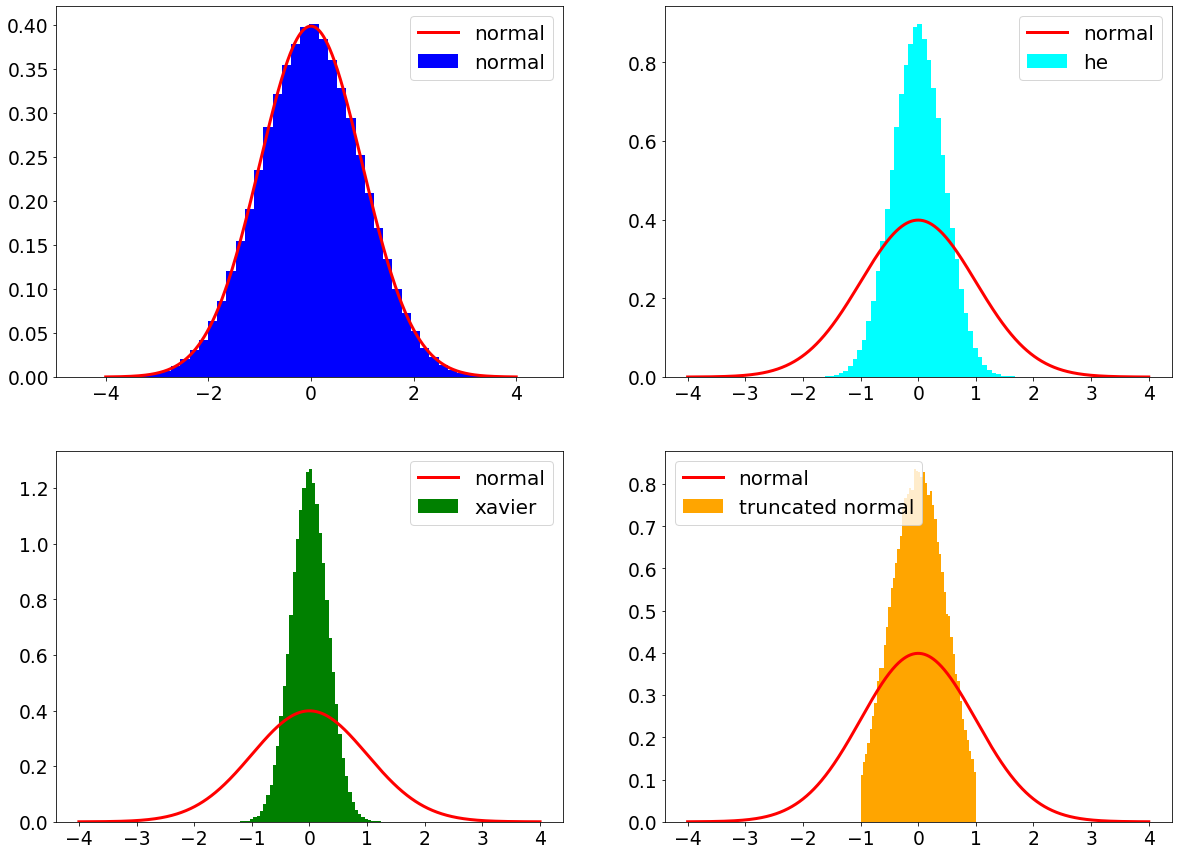

In [3]:
normal = np.random.randn((100000))
xavier = normal * np.sqrt(1 / 10)
he = normal * np.sqrt(2 / 10)

rad = 1 / np.sqrt(10)
X = truncated_normal(mean=0, sd=0.5, low=-1, upp=1)
trunc_normal = X.rvs(100000)

x = np.linspace(-4, 4, 1000, endpoint=True)
f = (1 / np.sqrt(2 * np.pi)) * np.exp(- 0.5 * x**2)

fig, ax = plt.subplots(2, 2, figsize=(20, 15))

ax[0, 0].hist(normal, 50, density=True, label='normal', color='blue')
ax[0, 0].plot(x, f, '-r', linewidth=3, label='normal')

ax[0, 1].hist(he, 50, density=True, label='he', color='cyan')
ax[0, 1].plot(x, f, '-r', linewidth=3, label='normal')

ax[1, 0].hist(xavier, 50, density=True, label='xavier', color='green')
ax[1, 0].plot(x, f, '-r', linewidth=3, label='normal')

ax[1, 1].hist(trunc_normal, 50, density=True, label='truncated normal', color='orange')
ax[1, 1].plot(x, f, '-r', linewidth=3, label='normal')

[axi.legend() for axi in ax.ravel()]
plt.show() 

## 2. Activation functions

Next, we define various **activation functions**. 

In principle, these activation functions can be interchanged at will, although performance might vary tremendously. In practice, one would prefer using a parameter initialization specific to the activation function, to ensure correct training behavior.

Below is a plot of the ones implemented here.

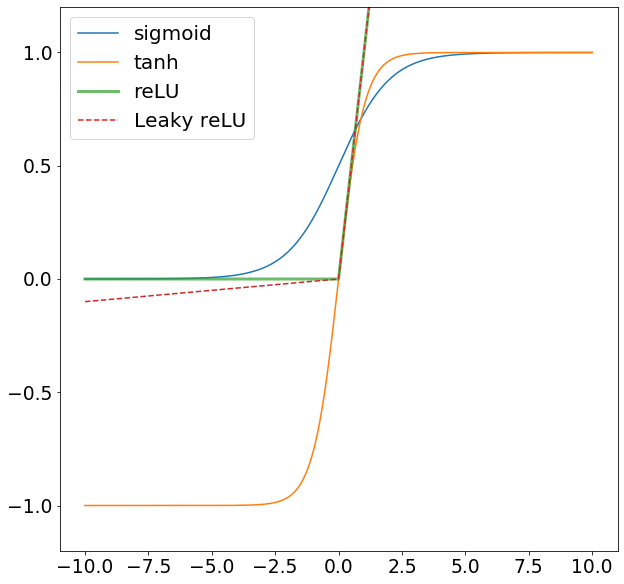

In [4]:
fig = plt.figure(figsize=(10, 10))

x = np.linspace(-10, 10, 1000, endpoint=True)
sigmoid = 1 / (1 + np.exp(-x))

plt.plot(x, sigmoid, label='sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.plot(x, np.maximum(0, x), linewidth=3, alpha=0.7, label='reLU')
plt.plot(x, np.maximum(0.01 * x, x), '--', label='Leaky reLU')

plt.ylim(-1.2, 1.2)
plt.legend()
plt.show()

## 3. Neural network arithmetics

### 3.1. Feedforward

Let's first take a look at how the network produces an output given an input, with the current parameters.

Let $\mathbf{X}$ be a column vector containing the input data, $\mathbf{Y}$ the output data vector, and $\mathbf{\hat{Y}}$ the predicted output vector.

$$
\begin{align}
    \mathbf{X} &= 
    \begin{bmatrix}
        x_{1} \\
        x_{2} \\
        \vdots \\
        x_{n}
    \end{bmatrix}
    & \mathbf{Y} & =
    \begin{bmatrix}
        y_{1} \\
        \vdots \\
        y_{m}
    \end{bmatrix}
    & \mathbf{\hat{Y}} & =
    \begin{bmatrix}
        \hat{y}_{1} \\
        \vdots \\
        \hat{y}_{m}
    \end{bmatrix}
\end{align}
$$

where $n$ and $m$ are the number of input and output nodes, respectively.

In a given layer, each neuron $i$ is connected to each input node $j$ by weight $w_{ij}$ and bias $b_i$. These parameters are arranged in arrays:

$$
\begin{align}
    \mathbf{W} &= 
    \begin{pmatrix}
        w_{11} & w_{12} & \ldots & w_{1n} \\
        w_{21} & w_{22} & \ldots & w_{2n} \\
        \vdots & \vdots & \ddots & \vdots \\
        w_{k1} & w_{k2} & \ldots & w_{kn}
    \end{pmatrix}
    & \mathbf{B} & =
    \begin{bmatrix}
        \hat{b}_{1} \\
        \vdots \\
        \hat{b}_{k}
    \end{bmatrix}
\end{align}
$$

where $k$ is the number of neurons in that layer. The network contains $l$ layers (including the output layer), we there fore have $l$ matrices for $\mathbf{W}$ and $\mathbf{B}$ each.

The input layer is passed through the first layer as such:

$$
\begin{align}
    \mathbf{H}_1 &=
    \begin{bmatrix}
        h_{11} \\
        \vdots \\
        h_{1k}
    \end{bmatrix}
    \ = \ \mathbf{W}_1 \cdot \mathbf{X} + \mathbf{B}_1
\end{align}
$$

The output is then passed through the activation function $f$:

$$
\mathbf{A} = f\left(\mathbf{H}\right)
$$

which is then passed as input to the next layer
$$
\begin{align}
    \mathbf{H}_2 &=
    \begin{bmatrix}
        h_{21} \\
        \vdots \\
        h_{2k}
    \end{bmatrix}
    \ = \ \mathbf{W}_2 \cdot \mathbf{A}_1 + \mathbf{B}_2
    \ = \ \mathbf{W}_2 \cdot f\left(\mathbf{W}_1 \cdot \mathbf{X} + \mathbf{B}_1\right) + \mathbf{B}_2
\end{align}
$$

This process is repeated until the output layer:

$$
\mathbf{\hat{Y}} = f\left(\mathbf{H_l}\right)
$$

$$
\begin{align}
    \mathbf{H}_l &=
    \begin{bmatrix}
        h_{l1} \\
        \vdots \\
        h_{lk}
    \end{bmatrix}
    \ = \ \mathbf{W}_l \cdot \mathbf{A}_{l-1} + \mathbf{B}_l
\end{align}
$$

### 3.2. Backpropagation

Once the feedforward pass is completed, we have a predicted output $\mathbf{\hat{Y}}$, which we compare to the desired output $\mathbf{Y}$. The comparison is measured by the loss $\mathbf{L}$.

For example the *L2 Norm* metric is $\mathbf{L} = \left(\mathbf{\hat{Y}} - \mathbf{Y}\right)^2$

The backpropagation aims to minimize the loss by modifying the network parameters. The first step is to compute the gradients of the loss with respect to all the parameters $\mathbf{W}_l$ and $\mathbf{B}_l$, for all $l$.

This is done using the chain rule:

$$
\frac{\partial \mathbf{L}}{\partial \mathbf{W}_k} = \frac{\partial \mathbf{L}}{\partial \mathbf{\hat{Y}}} \frac{\partial \mathbf{\hat{Y}}}{\partial \mathbf{H}_l} \frac{\partial \mathbf{H}_l}{\partial \mathbf{A}_{l-1}} \frac{\partial \mathbf{A}_{l-1}}{\partial \mathbf{H}_{l-2}} \ldots \frac{\partial \mathbf{A}_k}{\partial \mathbf{H}_k} \frac{\partial \mathbf{H}_k}{\partial \mathbf{W}_k}
$$

$$
\frac{\partial \mathbf{L}}{\partial \mathbf{B}_k} = \frac{\partial \mathbf{L}}{\partial \mathbf{\hat{Y}}} \frac{\partial \mathbf{\hat{Y}}}{\partial \mathbf{H}_l} \frac{\partial \mathbf{H}_l}{\partial \mathbf{A}_{l-1}} \frac{\partial \mathbf{A}_{l-1}}{\partial \mathbf{H}_{l-2}} \ldots \frac{\partial \mathbf{A}_k}{\partial \mathbf{H}_k} \frac{\partial \mathbf{H}_k}{\partial \mathbf{B}_k}
$$

We see that the gradient is made up of a 4 types of terms:

 - The loss gradient $\frac{\partial \mathbf{L}}{\partial \mathbf{\hat{Y}}}$

 - The activation gradient $\frac{\partial \mathbf{A}_i}{\partial \mathbf{H}_i}$

 - The layer gradient $\frac{\partial \mathbf{H}_i}{\partial \mathbf{A}_{i-1}}$
 
 - The weight/bias gradient $\frac{\partial \mathbf{H}}{\partial (w/b)}$
 
Each of these terms is easily computed. We'll use the aforementioned loss metric as an example.

$$
\begin{align}
    \mathbf{L} &= \left(\mathbf{\hat{Y}} - \mathbf{Y}\right)^2 \\
    & \Rightarrow \frac{\partial \mathbf{L}}{\partial \mathbf{\hat{Y}}} = -2 \left(\mathbf{Y} - \mathbf{\hat{Y}}\right)\\
    \mathbf{A}_i &= f\left(\mathbf{H}_i\right) \\
    & \Rightarrow \frac{\partial \mathbf{A}_i}{\partial \mathbf{H}_i} = f'(\mathbf{H}_i) \\
    \mathbf{H}_i &= \mathbf{W}_i \cdot \mathbf{A}_{i-1} + \mathbf{B}_i \\
    & \Rightarrow \frac{\partial \mathbf{H}_i}{\partial \mathbf{A}_{i-1}} = \mathbf{W}_i \\
    & \Rightarrow \frac{\partial \mathbf{H}_i}{\partial \mathbf{W}_{i}} = \mathbf{A}_{i-1} \\
    & \Rightarrow \frac{\partial \mathbf{H}_i}{\partial \mathbf{B}_{i}} = 1
\end{align}
$$

Putting everything together, we have:

$$
\frac{\partial \mathbf{L}}{\partial \mathbf{W}_k} = \left(\frac{\partial \mathbf{L}}{\partial \mathbf{\hat{Y}}}\right) \left(\prod_{i=k}^l f'\left(\mathbf{H}_i\right) \right) \left(\prod_{i=k+1}^l \mathbf{W}_i \right) \left(\mathbf{A}_{k-1}\right)
$$

$$
\frac{\partial \mathbf{L}}{\partial \mathbf{B}_k} = \left(\frac{\partial \mathbf{L}}{\partial \mathbf{\hat{Y}}}\right) \left(\prod_{i=k}^l f'\left(\mathbf{H}_i\right) \right) \left(\prod_{i=k+1}^l \mathbf{W}_i \right)
$$

## 4. Training

Let's say we want the network to predict sex based on weight and height alone.

We have the following training data:

|Name	 | Weight | Height |	Gender
|--------|--------|--------|--------------
|Alice	 |  133	  |   65   |      F
|Bob	 |  160	  |   72   |      M
|Charlie |  152	  |   70   |      M
|Diana	 |  120	  |   60   |      F

In [5]:
input_data = np.array([
  [133, 65],    # Alice
  [160, 72],    # Bob
  [152, 70],    # Charlie
  [120, 60],    # Diana
])
output_data = np.array([
  1, # Alice
  0, # Bob
  0, # Charlie
  1, # Diana
])


network = Network(2, 1, 2, 10, 'normal', 'sigmoid', learning_rate=0.01)
network.train(input_data, output_data, epochs=4000)
print()    # This is just to suppress printing of the return object of _train()

Training the network on 4 data points, for 4000 epochs, with learning rate = 0.01

Epoch 10 loss: 0.343
Epoch 20 loss: 0.313
Epoch 30 loss: 0.282
Epoch 40 loss: 0.255
Epoch 50 loss: 0.235
Epoch 60 loss: 0.221
Epoch 70 loss: 0.213
Epoch 80 loss: 0.208
Epoch 90 loss: 0.204
Epoch 100 loss: 0.201
Epoch 110 loss: 0.198
Epoch 120 loss: 0.195
Epoch 130 loss: 0.193
Epoch 140 loss: 0.190
Epoch 150 loss: 0.188
Epoch 160 loss: 0.186
Epoch 170 loss: 0.183
Epoch 180 loss: 0.181
Epoch 190 loss: 0.178
Epoch 200 loss: 0.176
Epoch 210 loss: 0.174
Epoch 220 loss: 0.171
Epoch 230 loss: 0.169
Epoch 240 loss: 0.166
Epoch 250 loss: 0.164
Epoch 260 loss: 0.161
Epoch 270 loss: 0.159
Epoch 280 loss: 0.156
Epoch 290 loss: 0.154
Epoch 300 loss: 0.151
Epoch 310 loss: 0.149
Epoch 320 loss: 0.147
Epoch 330 loss: 0.144
Epoch 340 loss: 0.142
Epoch 350 loss: 0.139
Epoch 360 loss: 0.137
Epoch 370 loss: 0.135
Epoch 380 loss: 0.132
Epoch 390 loss: 0.130
Epoch 400 loss: 0.128
Epoch 410 loss: 0.126
Epoch 420 loss: 0.124
Ep

Epoch 3860 loss: 0.006
Epoch 3870 loss: 0.006
Epoch 3880 loss: 0.006
Epoch 3890 loss: 0.006
Epoch 3900 loss: 0.006
Epoch 3910 loss: 0.006
Epoch 3920 loss: 0.006
Epoch 3930 loss: 0.006
Epoch 3940 loss: 0.006
Epoch 3950 loss: 0.006
Epoch 3960 loss: 0.006
Epoch 3970 loss: 0.006
Epoch 3980 loss: 0.006
Epoch 3990 loss: 0.006
Epoch 4000 loss: 0.006




We see that a modest size network with 2 hidden layers of 10 neurons each is able to fit the training set very well.
Note here that the training set is **very** small, this results in the network being quite unstable. Changing any parameter slightly may result in very different results.

Let's test this network on some previously unseen data (testing set).

In [6]:
emily = np.array([128, 63])    # 128 pounds, 63 inches
frank = np.array([155, 68])    # 155 pounds, 68 inches
print("Emily: %.3f" % network.feedforward(emily))    # 0.924 -> Female (correct)
print("Frank: %.3f" % network.feedforward(frank))    # 0.058 -> Male (correct)

Emily: 0.924
Frank: 0.058


We can also test it on ourselves

In [7]:
Alex = np.array([150, 70])    # 150 pounds, 70 inches
print("Alex: %.3f" % network.feedforward(Alex))    # 0.153 -> I am a guy, good.

Alex: 0.153


The neural network has 2 layers with 10 each.
There is a total of 460 parameters to be optimized
	They are initialized with the 'normal' distribution
	Each neuron uses the 'sigmoid'activation function


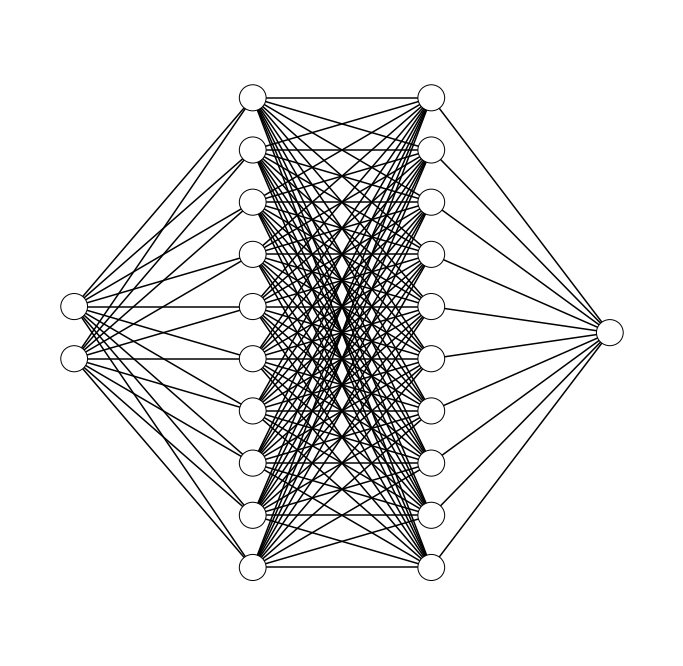

In [8]:
network.summary()
network.draw()

460 parameters is quite a lot to fit only 4 data points (8 points total)!!

In practice, neural networks are much better at learning small number than big ones.
Let's try and shift the training set by its mean and see what happens.

In [9]:
input_data = np.array([
  [133, 65],    # Alice
  [160, 72],    # Bob
  [152, 70],    # Charlie
  [120, 60],    # Diana
])

print(f"The average weight and height in this data set are {np.mean(input_data, 0)[0]} (lb) and {np.mean(input_data, 0)[1]} (inches).")

#input_data_shifted = 
input_data_shifted = input_data - np.tile(np.mean(input_data, 0), (len(input_data), 1))
print(f"The shifted input data looks like:")
print(input_data_shifted)
print(f"The output data hasn't changed")

network = Network(2, 1, 1, 2, 'normal', 'sigmoid')
network.train(input_data_shifted, output_data)

emily = np.array([128, 63])    # 128 pounds, 63 inches
frank = np.array([155, 68])    # 155 pounds, 68 inches
Alex = np.array([150, 70])     # 150 pounds, 70 inches

emily_shifted = emily - np.tile(np.mean(input_data, 0), (1, 1))
frank_shifted = frank - np.tile(np.mean(input_data, 0), (1, 1))
Alex_shifted = Alex - np.tile(np.mean(input_data, 0), (1, 1))

print("Emily: %.3f" % network.feedforward(emily_shifted))    # 0.924 -> Female (correct)
print("Frank: %.3f" % network.feedforward(frank_shifted))    # 0.065 -> Male (correct)
print("Alex: %.3f" % network.feedforward(Alex_shifted))      # 0.065 -> Male (correct)

The average weight and height in this data set are 141.25 (lb) and 66.75 (inches).
The shifted input data looks like:
[[ -8.25  -1.75]
 [ 18.75   5.25]
 [ 10.75   3.25]
 [-21.25  -6.75]]
The output data hasn't changed
Training the network on 4 data points, for 400 epochs, with learning rate = 0.1

Epoch 10 loss: 0.224
Epoch 20 loss: 0.162
Epoch 30 loss: 0.123
Epoch 40 loss: 0.097
Epoch 50 loss: 0.078
Epoch 60 loss: 0.064
Epoch 70 loss: 0.054
Epoch 80 loss: 0.046
Epoch 90 loss: 0.040
Epoch 100 loss: 0.035
Epoch 110 loss: 0.031
Epoch 120 loss: 0.028
Epoch 130 loss: 0.026
Epoch 140 loss: 0.023
Epoch 150 loss: 0.021
Epoch 160 loss: 0.020
Epoch 170 loss: 0.018
Epoch 180 loss: 0.017
Epoch 190 loss: 0.016
Epoch 200 loss: 0.015
Epoch 210 loss: 0.014
Epoch 220 loss: 0.013
Epoch 230 loss: 0.013
Epoch 240 loss: 0.012
Epoch 250 loss: 0.011
Epoch 260 loss: 0.011
Epoch 270 loss: 0.010
Epoch 280 loss: 0.010
Epoch 290 loss: 0.010
Epoch 300 loss: 0.009
Epoch 310 loss: 0.009
Epoch 320 loss: 0.009
Epoch 

The neural network has 1 layers with 2 each.
There is a total of 6 parameters to be optimized
	They are initialized with the 'normal' distribution
	Each neuron uses the 'sigmoid'activation function


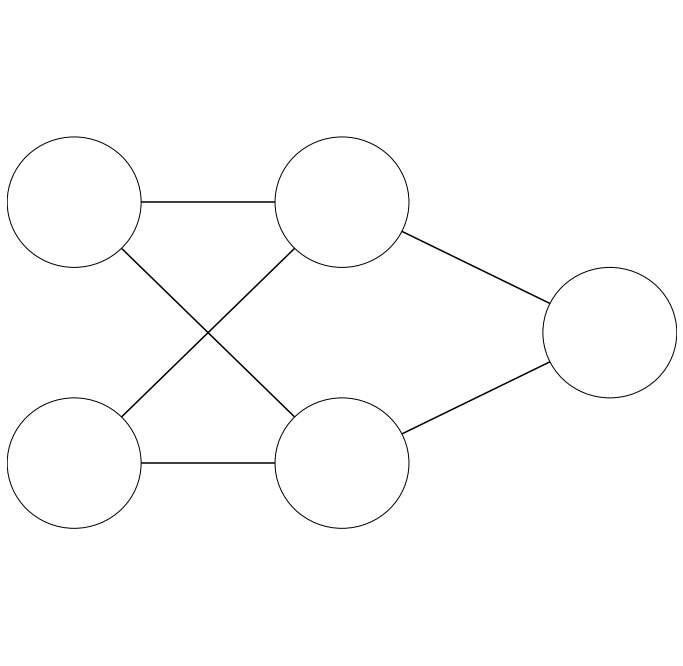

In [10]:
network.summary()
network.draw()

We observe that the neural network achieves the same level of performance as previous, albeit with a **LOT** less parameters, and much more ease.

## 5. Hyper-parameters

Let's look at the effect that some of the hyperparameters of the network have.

### 5.1. Initialization method for weights and biases

In [11]:
network = Network(2, 1, 1, 2, 'zeros')
L1 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2, 1, 1, 2, 'ones')
L2 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2, 1, 1, 2, 'random')
L3 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2, 1, 1, 2, 'normal')
L4 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2, 1, 1, 2, 'truncated_normal')
L5 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2, 1, 1, 2, 'xavier')
L6 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2, 1, 1, 2, 'he')
L7 = network.train(input_data_shifted, output_data, epochs=100)

Training the network on 4 data points, for 100 epochs, with learning rate = 0.1

Epoch 10 loss: 0.250
Epoch 20 loss: 0.238
Epoch 30 loss: 0.174
Epoch 40 loss: 0.131
Epoch 50 loss: 0.102
Epoch 60 loss: 0.081
Epoch 70 loss: 0.067
Epoch 80 loss: 0.056
Epoch 90 loss: 0.048
Epoch 100 loss: 0.041

Training the network on 4 data points, for 100 epochs, with learning rate = 0.1

Epoch 10 loss: 0.470
Epoch 20 loss: 0.423
Epoch 30 loss: 0.283
Epoch 40 loss: 0.144
Epoch 50 loss: 0.102
Epoch 60 loss: 0.080
Epoch 70 loss: 0.066
Epoch 80 loss: 0.055
Epoch 90 loss: 0.047
Epoch 100 loss: 0.041

Training the network on 4 data points, for 100 epochs, with learning rate = 0.1

Epoch 10 loss: 0.363
Epoch 20 loss: 0.189
Epoch 30 loss: 0.117
Epoch 40 loss: 0.090
Epoch 50 loss: 0.072
Epoch 60 loss: 0.060
Epoch 70 loss: 0.051
Epoch 80 loss: 0.044
Epoch 90 loss: 0.038
Epoch 100 loss: 0.034

Training the network on 4 data points, for 100 epochs, with learning rate = 0.1

Epoch 10 loss: 0.224
Epoch 20 loss: 0.16

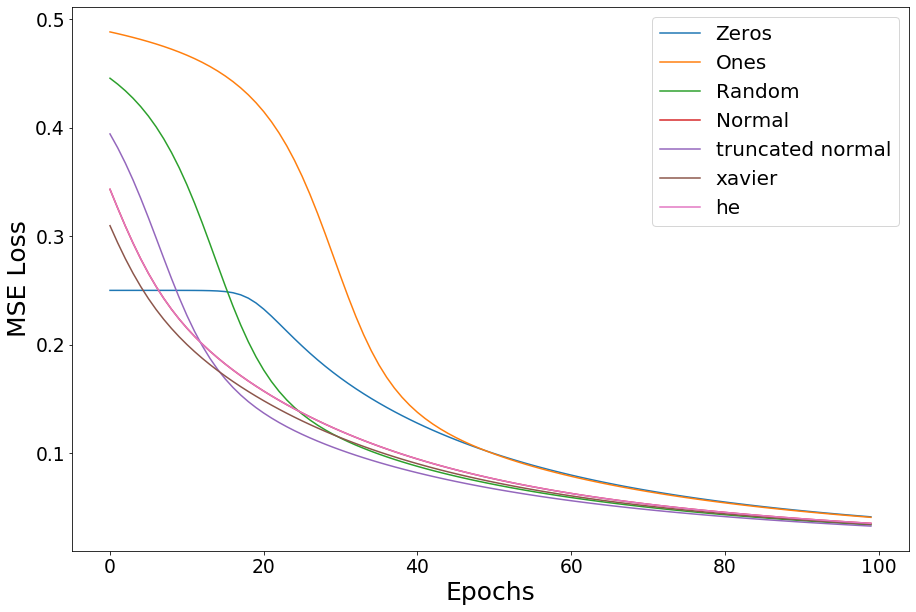

In [12]:
# Plot training
plt.figure(figsize=(15,10))
plt.plot(L1,label='Zeros')
plt.plot(L2,label='Ones')
plt.plot(L3,label='Random')
plt.plot(L4,label='Normal')
plt.plot(L5,label='truncated normal')
plt.plot(L6,label='xavier')
plt.plot(L7,label='he')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 5.2. Learning rate

In [13]:
network = Network(2,1,1,2,'normal','sigmoid',1)
L1 = network.train(input_data_shifted, output_data)
network = Network(2,1,1,2,'normal','sigmoid',0.1)
L2 = network.train(input_data_shifted, output_data)
network = Network(2,1,1,2,'normal','sigmoid',0.01)
L3 = network.train(input_data_shifted, output_data)

Training the network on 4 data points, for 400 epochs, with learning rate = 1

Epoch 10 loss: 0.032
Epoch 20 loss: 0.014
Epoch 30 loss: 0.009
Epoch 40 loss: 0.006
Epoch 50 loss: 0.005
Epoch 60 loss: 0.004
Epoch 70 loss: 0.003
Epoch 80 loss: 0.003
Epoch 90 loss: 0.003
Epoch 100 loss: 0.002
Epoch 110 loss: 0.002
Epoch 120 loss: 0.002
Epoch 130 loss: 0.002
Epoch 140 loss: 0.002
Epoch 150 loss: 0.001
Epoch 160 loss: 0.001
Epoch 170 loss: 0.001
Epoch 180 loss: 0.001
Epoch 190 loss: 0.001
Epoch 200 loss: 0.001
Epoch 210 loss: 0.001
Epoch 220 loss: 0.001
Epoch 230 loss: 0.001
Epoch 240 loss: 0.001
Epoch 250 loss: 0.001
Epoch 260 loss: 0.001
Epoch 270 loss: 0.001
Epoch 280 loss: 0.001
Epoch 290 loss: 0.001
Epoch 300 loss: 0.001
Epoch 310 loss: 0.001
Epoch 320 loss: 0.001
Epoch 330 loss: 0.001
Epoch 340 loss: 0.001
Epoch 350 loss: 0.001
Epoch 360 loss: 0.001
Epoch 370 loss: 0.001
Epoch 380 loss: 0.001
Epoch 390 loss: 0.001
Epoch 400 loss: 0.001

Training the network on 4 data points, for 400 ep

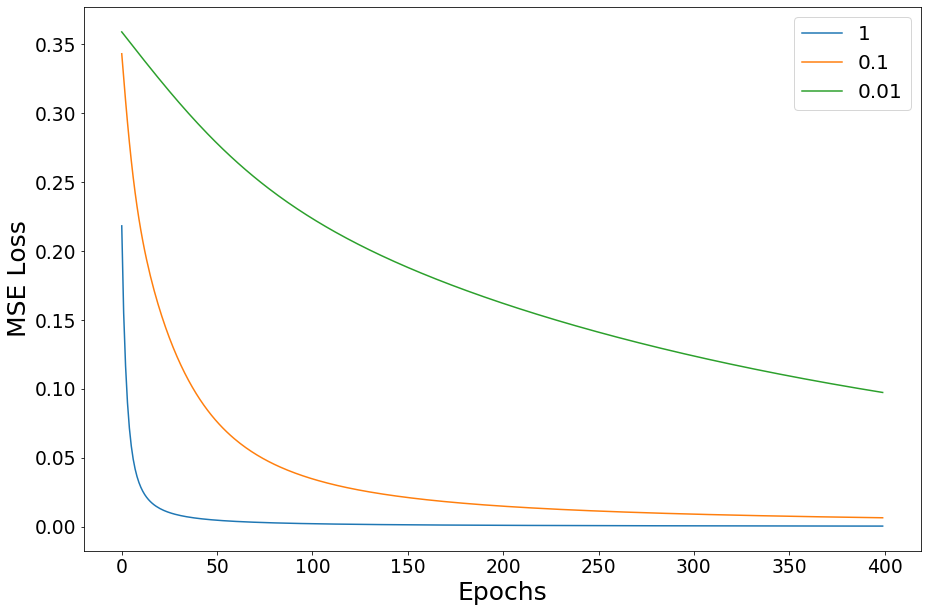

In [14]:
# Plot training
plt.figure(figsize=(15,10))
plt.plot(L1,label='1')
plt.plot(L2,label='0.1')
plt.plot(L3,label='0.01')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### 5.3. Activation functions

This section still needs a bit of work, the activations based on reLU require special considerations when used with small datasets.

In [15]:
network = Network(2,1,1,2,'normal','sigmoid')
L1 = network.train(input_data_shifted, output_data, epochs=100)
network = Network(2,1,1,2,'normal','tanh')
L2 = network.train(input_data_shifted, output_data, epochs=100)

Training the network on 4 data points, for 100 epochs, with learning rate = 0.1

Epoch 10 loss: 0.224
Epoch 20 loss: 0.162
Epoch 30 loss: 0.123
Epoch 40 loss: 0.097
Epoch 50 loss: 0.078
Epoch 60 loss: 0.064
Epoch 70 loss: 0.054
Epoch 80 loss: 0.046
Epoch 90 loss: 0.040
Epoch 100 loss: 0.035

Training the network on 4 data points, for 100 epochs, with learning rate = 0.1

Epoch 10 loss: 0.007
Epoch 20 loss: 0.003
Epoch 30 loss: 0.002
Epoch 40 loss: 0.002
Epoch 50 loss: 0.001
Epoch 60 loss: 0.001
Epoch 70 loss: 0.001
Epoch 80 loss: 0.001
Epoch 90 loss: 0.001
Epoch 100 loss: 0.001



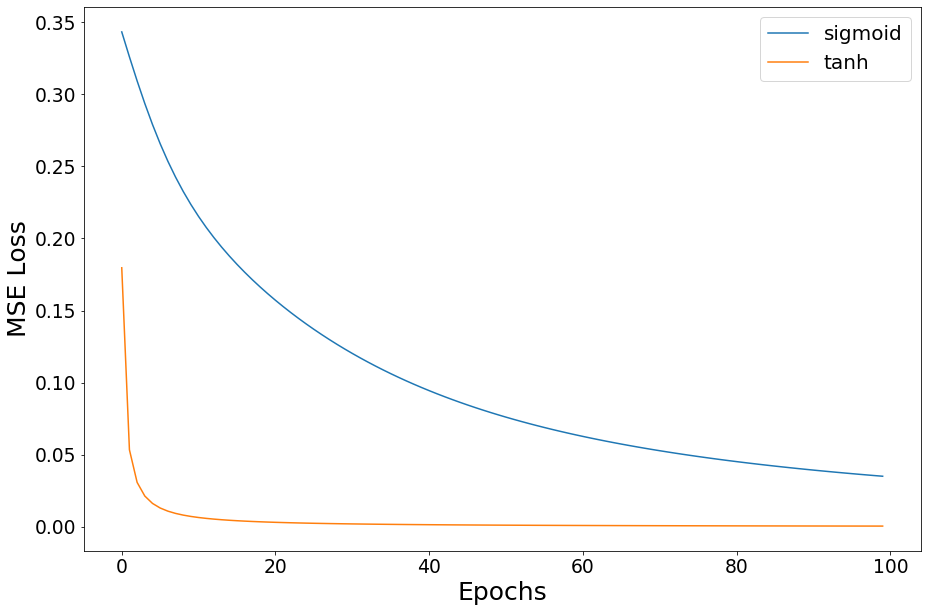

In [16]:
# Plot training
plt.figure(figsize=(15,10))
plt.plot(L1,label='sigmoid')
plt.plot(L2,label='tanh')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()